In [1]:
# data: https://download.pytorch.org/tutorial/data.zip
import io
import os
import unicodedata
import string
import glob

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories



# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))
    
    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])
    
    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones')) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1) # 1,57
        
    def forward(self,input_tensor,hidden_tensor):
        combined = torch.cat((input_tensor,hidden_tensor),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden
    
    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)

In [4]:
category_lines,all_categories = load_data()

In [5]:
n_categories = len(all_categories)

In [6]:
N_LETTERS

57

In [7]:
n_hidden = 128

In [8]:
rnn = RNN(N_LETTERS,n_hidden,n_categories)

In [9]:
input_tensor = letter_to_tensor('A')

In [10]:
hidden_tensor = rnn.init_hidden()

In [11]:
output,next_hidden = rnn(input_tensor,hidden_tensor)

In [12]:
output.shape

torch.Size([1, 18])

In [13]:
next_hidden.shape

torch.Size([1, 128])

In [14]:
input_tensor = line_to_tensor('Ranuga')
hidden_tensor = rnn.init_hidden()
output,next_hidden = rnn(input_tensor[0],hidden_tensor)

In [15]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [16]:
category_from_output(output)

'Arabic'

In [17]:
criterion = nn.NLLLoss()

In [18]:
lr = 0.005

In [19]:
optimizer = torch.optim.SGD(rnn.parameters(),lr=lr)

In [20]:
epochs = 100

In [21]:
def train(line_tensor,category_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    loss = criterion(output,category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return output,loss.item()

In [22]:
current_loss = 0
all_losses = []

In [23]:
plot_steps,print_steps = 100000,5

In [24]:
n_iters = 1000000

In [25]:
from tqdm import tqdm

In [26]:
iteration = tqdm(range(n_iters))
for i in iteration:
    category,line,category_tensor,line_tensor = random_training_example(category_lines,all_categories)
    output,loss = train(line_tensor,category_tensor)
    current_loss += loss
    if (i+1) % plot_steps ==0:
        all_losses.append(current_loss/plot_steps)
        current_loss = 0
        guess = category_from_output(output)
        correct = 'CORRECT' if guess == category else f'WRONG (Guess : {guess} | Acctual : {category})'
        iteration.set_description(f'{loss} {line} | {guess} {category} | {correct}')
        iteration.refresh()

4.536567687988281 Gros | Portuguese German | WRONG (Guess : Portuguese | Acctual : German): 100%|██████████| 1000000/1000000 [15:26<00:00, 1078.94it/s]


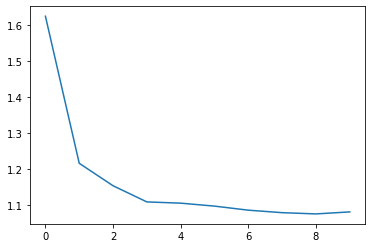

In [27]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [31]:
def predict(input_line):
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output,hidden = rnn(input_tensor[i],hidden)
        guess = category_from_output(output)
        print(guess)

In [ ]:
while True:
    sentence = input('Input a Name : ')
    if sentence == 'quit':
        break
    predict(sentence)

Input a Name :  lol


Chinese
